In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import json

from sklearn.metrics import (precision_score, recall_score, f1_score,
                             hamming_loss, jaccard_score, coverage_error,
                             label_ranking_average_precision_score)

from solr_query import query_all
from numpy._typing import NDArray
from scipy.optimize import minimize
from matplotlib import pyplot as plt

import nest_asyncio
import asyncio

from collections import Counter

# Apply the nest_asyncio patch
nest_asyncio.apply()

# Part 1 | Evaluation of the current system

## Load data

In [2]:
idx2url = pd.read_csv('dataset/urls.csv')['url'].to_numpy()
idx2url[:10]

array(['https://huginternet-hug23sitestma172.ideative.io/en/actualite/csfe/18th-annual-ski-and-snowboard-camp-young-transplant-patients-will-took-place-march',
       'https://huginternet-hug23sitestma172.ideative.io/en/actualite/csfe/animated-video-better-understanding-portal-hypertension',
       'https://huginternet-hug23sitestma172.ideative.io/en/actualite/csfe/annual-rapport-discover-key-figures-2018-2020-swiss-pediatric-liver-center',
       'https://huginternet-hug23sitestma172.ideative.io/en/actualite/csfe/association-mahana4kids-organizes-marche-pour-vie-promote-organ-donation-and-support',
       'https://huginternet-hug23sitestma172.ideative.io/en/actualite/csfe/big-yellow-friday-yellow-month-day-and-month-dedicated-children-liver-disease',
       'https://huginternet-hug23sitestma172.ideative.io/en/actualite/csfe/congratulation-all-participants-marche-pour-vie-organized-mahana4kids-association',
       'https://huginternet-hug23sitestma172.ideative.io/en/actualite/csfe/eaps

In [3]:
queries = pd.read_csv('dataset/queries.csv')
queries['query'] = queries['query'].str.replace('"', '').str.strip()
queries[:10]

,url,query
0,https://huginternet-hug23sitestma172.ideative....,details on 18th annual ski and snowboard camp ...
1,https://huginternet-hug23sitestma172.ideative....,ski camp for young transplant patients Anzère ...
2,https://huginternet-hug23sitestma172.ideative....,2019 ski and snowboard camp for young transpla...
3,https://huginternet-hug23sitestma172.ideative....,Anzère ski camp for transplant kids March 2019
4,https://huginternet-hug23sitestma172.ideative....,annual ski camp for young transplant recipient...
5,https://huginternet-hug23sitestma172.ideative....,portal hypertension animation
6,https://huginternet-hug23sitestma172.ideative....,portal hypertension educational video
7,https://huginternet-hug23sitestma172.ideative....,understanding portal hypertension
8,https://huginternet-hug23sitestma172.ideative....,portal hypertension patient education
9,https://huginternet-hug23sitestma172.ideative....,portal hypertension HUG video


In [4]:
url2idx = dict(zip(idx2url, range(len(idx2url))))

In [5]:
idx2query = queries['query'].unique()

In [6]:
query2idx = dict(zip(idx2query, range(len(idx2query))))

In [7]:
with open('results/results_scraped_initial_version.json') as f:
    result = json.load(f)

## Create evaluation datasets

In [8]:
ground_truth = np.zeros((len(idx2query), len(idx2url)), dtype=int)
for idx, (url, query) in queries.iterrows():
    url_idx = url2idx[url]
    query_idx = query2idx[query]
    
    # 1 = relevant, 0 = not relevant
    ground_truth[query_idx, url_idx] = 1
    
# distribution of ground_truth
Counter(ground_truth.sum(axis=-1))

Counter({1: 242, 2: 2})

In [9]:
def binarize(result_queries: list[str], result_urls: list[list[str]], *, k: int = 10) -> NDArray[int]:
    binarized_result = np.zeros((len(idx2query), len(idx2url)), dtype=int)

    for query, urls in zip(result_queries, result_urls):
        for url in urls[:k]:  # for @k metrics we select the first k results
            if url not in url2idx:
                continue  # skip anything that is not /en/csfe or /en/actualite/csfe
            
            url_idx = url2idx[url]
            query_idx = query2idx[query]
            
            # 1 = relevant, 0 = not relevant
            binarized_result[query_idx, url_idx] = 1
            
    return binarized_result

actual_results = binarize(result.keys(), result.values())

# distribution of actual_results
Counter(actual_results.sum(axis=-1))

Counter({0: 162, 1: 67, 2: 10, 4: 3, 6: 1, 5: 1})

## Evaluation

In [10]:
y_true = ground_truth
y_pred = actual_results

precision = precision_score(y_true, y_pred, average='samples', zero_division=0)
recall = recall_score(y_true, y_pred, average='samples')
f1 = f1_score(y_true, y_pred, average='samples', zero_division=0)
hamming = hamming_loss(y_true, y_pred)
jaccard = jaccard_score(y_true, y_pred, average='samples')
coverage = coverage_error(y_true, y_pred)
lrap = label_ranking_average_precision_score(y_true, y_pred)

print('Precision:', precision)
print('Recall:', recall)
print('F1 Score:', f1)
print('Hamming Loss:', hamming)
print('Jaccard Similarity Score:', jaccard)
print('Coverage Error:', coverage)
print('Label Ranking Average Precision (LRAP):', lrap)

Precision: 0.260724043715847
Recall: 0.28688524590163933
F1 Score: 0.26701795472287276
Hamming Loss: 0.017704918032786884
Jaccard Similarity Score: 0.260724043715847
Coverage Error: 36.03688524590164
Label Ranking Average Precision (LRAP): 0.2751502732240447


# Part 2 | Possible improvements

## Using default weights

In [11]:
fields = [
    'tm_X3b_en_body_value',
    'tm_X3b_en_field_ref_desc',
    'tm_X3b_en_field_ref_titre',
    'tm_X3b_en_mots_cles',
    'tm_X3b_en_title',
    'tm_X3b_en_corps_value',
    'tm_X3b_en_paragraphs_text',
    'tm_X3b_en_name',
    'tm_X3b_en_mission_value',
    'tm_X3b_en_text_content',
    # evaluate without meta information for now
    # tm_X3b_en_full_meta_tag
]

weights = [1] * len(fields)  # use system weights
default_results = asyncio.run(query_all(idx2query, fields, weights))

In [12]:
default_results_binary = binarize(idx2query, default_results)

# distribution of default_results_binary
Counter(default_results_binary.sum(axis=-1))

Counter({1: 48,
         3: 45,
         2: 42,
         4: 25,
         9: 20,
         10: 18,
         8: 16,
         6: 11,
         0: 9,
         7: 6,
         5: 4})

In [13]:
y_true = ground_truth
y_pred = default_results_binary

precision = precision_score(y_true, y_pred, average='samples', zero_division=0)
recall = recall_score(y_true, y_pred, average='samples')
f1 = f1_score(y_true, y_pred, average='samples', zero_division=0)
hamming = hamming_loss(y_true, y_pred)
jaccard = jaccard_score(y_true, y_pred, average='samples')
coverage = coverage_error(y_true, y_pred)
lrap = label_ranking_average_precision_score(y_true, y_pred)

print('Precision:', precision)
print('Recall:', recall)
print('F1 Score:', f1)
print('Hamming Loss:', hamming)
print('Jaccard Similarity Score:', jaccard)
print('Coverage Error:', coverage)
print('Label Ranking Average Precision (LRAP):', lrap)

Precision: 0.2982191647150663
Recall: 0.7233606557377049
F1 Score: 0.3815278073474795
Hamming Loss: 0.07155737704918033
Jaccard Similarity Score: 0.2981819068909233
Coverage Error: 16.868852459016395
Label Ranking Average Precision (LRAP): 0.30358801717408346


## Optimizing weights to maximize Recall@10

In [14]:
def fn_to_optimize(boost_fields: NDArray[float]) -> float:
    res = asyncio.run(query_all(idx2query, fields, boost_fields))
    bin_res = binarize(idx2query, res)
    metric = recall_score(ground_truth, bin_res, average='samples')
    print(f'{metric:.4f},{','.join([f"{bst:.4f}" for bst in boost_fields])}')
    
    # we minimize the inverse of the recall
    return 1 - metric

print(f'recall@10,{','.join([fld for fld in fields])}')

bounds = [(0, 10)] * len(fields)  # each weight should be greater than zero
initial_guess = np.ones(len(fields))  # default weights as a starting point

best_boost_powell = minimize(
    fn_to_optimize, 
    initial_guess, 
    method='Powell',
    bounds=bounds, 
    options={
        'maxiter': 100,
        'disp': True,
        'ftol': 1e-4
    }
)

print("Optimized boost fields:", best_boost_powell.x)
print("Objective function value:", best_boost_powell.fun)
print("Optimization success:", best_boost_powell.success)
print("Optimization message:", best_boost_powell.message)

recall@10,tm_X3b_en_body_value,tm_X3b_en_field_ref_desc,tm_X3b_en_field_ref_titre,tm_X3b_en_mots_cles,tm_X3b_en_title,tm_X3b_en_corps_value,tm_X3b_en_paragraphs_text,tm_X3b_en_name,tm_X3b_en_mission_value,tm_X3b_en_text_content
0.7234,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
0.5246,3.8197,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
0.3361,6.1803,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
0.7152,2.3607,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
0.7234,1.4590,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
0.7234,1.8215,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
0.7234,1.6403,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
0.7234,1.5710,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
0.7234,1.5282,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
0.7234,1.5018,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
0.

ERROR:root:Search query at index 46 generated an exception: 


0.7992,1.4590,1.2776,1.4881,2.3607,2.4686,0.8875,0.6384,1.0000,1.0000,1.0000
0.8033,1.4590,1.2776,1.4881,2.3607,2.4686,0.8875,0.6430,1.0000,1.0000,1.0000
0.8033,1.4590,1.2776,1.4881,2.3607,2.4686,0.8875,0.6441,1.0000,1.0000,1.0000
0.8033,1.4590,1.2776,1.4881,2.3607,2.4686,0.8875,0.6448,1.0000,1.0000,1.0000
0.8033,1.4590,1.2776,1.4881,2.3607,2.4686,0.8875,0.6452,1.0000,1.0000,1.0000
0.8033,1.4590,1.2776,1.4881,2.3607,2.4686,0.8875,0.6455,1.0000,1.0000,1.0000
0.8033,1.4590,1.2776,1.4881,2.3607,2.4686,0.8875,0.6456,1.0000,1.0000,1.0000
0.8033,1.4590,1.2776,1.4881,2.3607,2.4686,0.8875,0.6457,1.0000,1.0000,1.0000
0.8033,1.4590,1.2776,1.4881,2.3607,2.4686,0.8875,0.6458,1.0000,1.0000,1.0000
0.8033,1.4590,1.2776,1.4881,2.3607,2.4686,0.8875,0.6458,1.0000,1.0000,1.0000
0.7541,1.4590,1.2776,1.4881,2.3607,2.4686,0.8875,0.6458,3.8197,1.0000,1.0000
0.6066,1.4590,1.2776,1.4881,2.3607,2.4686,0.8875,0.6458,6.1803,1.0000,1.0000
0.8115,1.4590,1.2776,1.4881,2.3607,2.4686,0.8875,0.6458,2.3607,1.0000,1.0000

KeyboardInterrupt: 

In [15]:
# result of the optimization
powell_weights = [1.4590,1.2776,1.4881,2.3607,2.4686,0.8875,0.6458,2.1682,0.8541,9.6556]

Copy cell outputs to `powell.csv`

## Analyze the results

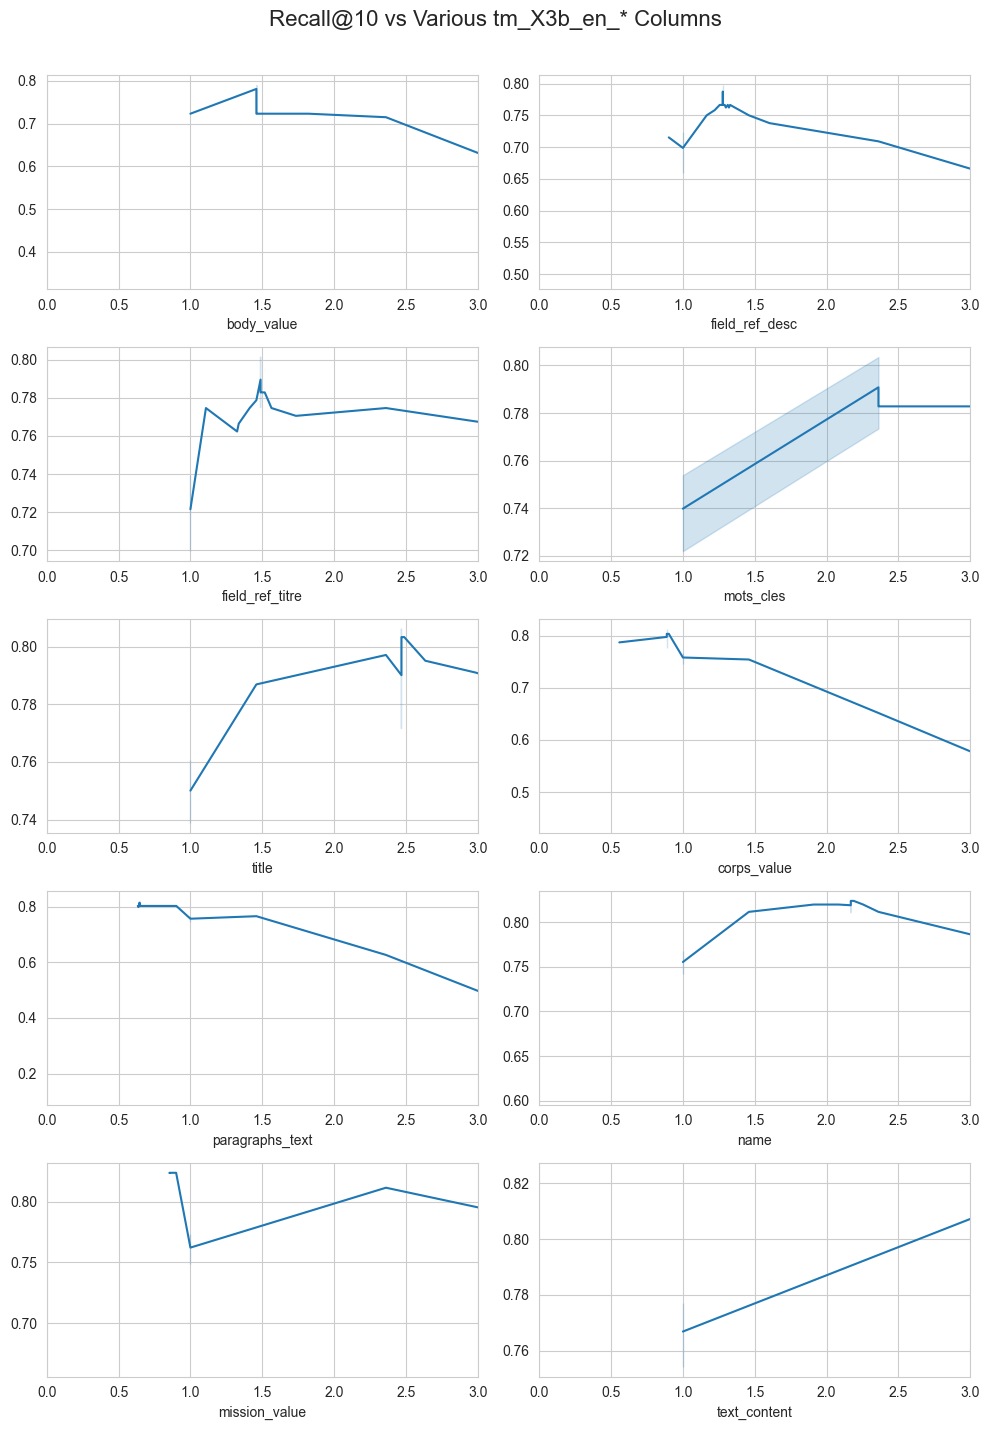

In [16]:
data = pd.read_csv('results/powell.csv')
# Create a 5x2 grid of line plots with specified adjustments
fig, axes = plt.subplots(5, 2, figsize=(10, 15))

for ax, col in zip(axes.flatten(), fields):
    sns.lineplot(x=data[col], y=data['recall@10'], ax=ax)
    ax.set_xlim(0, 3)
    ax.set_xlabel(col.replace('tm_X3b_en_', ''))
    ax.set_ylabel('')

# Add a single title explaining the y-axis
fig.suptitle('Recall@10 vs Various tm_X3b_en_* Columns', fontsize=16)

plt.tight_layout(rect=(0.0, 0.03, 1.0, 0.97))
plt.show()

# Part 3 | Introduction of schema.org entities

## Using default weights

In [11]:
fields = [
    'tm_X3b_en_body_value',
    'tm_X3b_en_field_ref_desc',
    'tm_X3b_en_field_ref_titre',
    'tm_X3b_en_mots_cles',
    'tm_X3b_en_title',
    'tm_X3b_en_corps_value',
    'tm_X3b_en_paragraphs_text',
    'tm_X3b_en_name',
    'tm_X3b_en_mission_value',
    'tm_X3b_en_text_content',
    'tm_X3b_en_full_meta_tag'
]

weights = [1] * len(fields)  # use system weights
default_results = asyncio.run(query_all(idx2query, fields, weights))

KeyboardInterrupt: 

In [18]:
default_results_binary = binarize(idx2query, default_results)

# distribution of default_results_binary
Counter(default_results_binary.sum(axis=-1))

Counter({3: 49,
         2: 49,
         1: 34,
         4: 26,
         9: 21,
         10: 19,
         8: 14,
         6: 12,
         0: 9,
         7: 6,
         5: 5})

In [19]:
y_true = ground_truth
y_pred = default_results_binary

precision = precision_score(y_true, y_pred, average='samples', zero_division=0)
recall = recall_score(y_true, y_pred, average='samples')
f1 = f1_score(y_true, y_pred, average='samples', zero_division=0)
hamming = hamming_loss(y_true, y_pred)
jaccard = jaccard_score(y_true, y_pred, average='samples')
coverage = coverage_error(y_true, y_pred)
lrap = label_ranking_average_precision_score(y_true, y_pred)

print('Precision:', precision)
print('Recall:', recall)
print('F1 Score:', f1)
print('Hamming Loss:', hamming)
print('Jaccard Similarity Score:', jaccard)
print('Coverage Error:', coverage)
print('Label Ranking Average Precision (LRAP):', lrap)

Precision: 0.2878252667187093
Recall: 0.7438524590163934
F1 Score: 0.3787825562415726
Hamming Loss: 0.07319672131147541
Jaccard Similarity Score: 0.28778800889456624
Coverage Error: 15.987704918032787
Label Ranking Average Precision (LRAP): 0.29278428311215277


## Optimizing weights to maximize Recall@10

In [ ]:
def fn_to_optimize(boost_fields: NDArray[float]) -> float:
    res = asyncio.run(query_all(idx2query, fields, boost_fields))
    bin_res = binarize(idx2query, res)
    metric = recall_score(ground_truth, bin_res, average='samples')
    print(f'{metric:.4f},{','.join([f"{bst:.4f}" for bst in boost_fields])}')
    
    # we minimize the inverse of the recall
    return 1 - metric

print(f'recall@10,{','.join([fld for fld in fields])}')

bounds = [(0, 10)] * len(fields)  # each weight should be greater than zero
# initial_guess = np.ones(len(fields))  # default weights as a starting point

best_boost_powell = minimize(
    fn_to_optimize, 
    # initial_guess, 
    np.asarray([1.4590,1.2361,1.3777,3.8196,2.2498,0.8757,0.5573,1.2532,0.9381,3.8194,1.4224]),
    method='Powell',
    bounds=bounds, 
    options={
        'maxiter': 25,
        'disp': True,
        'ftol': 1e-4
    }
)

print("Optimized boost fields:", best_boost_powell.x)
print("Objective function value:", best_boost_powell.fun)
print("Optimization success:", best_boost_powell.success)
print("Optimization message:", best_boost_powell.message)

recall@10,tm_X3b_en_body_value,tm_X3b_en_field_ref_desc,tm_X3b_en_field_ref_titre,tm_X3b_en_mots_cles,tm_X3b_en_title,tm_X3b_en_corps_value,tm_X3b_en_paragraphs_text,tm_X3b_en_name,tm_X3b_en_mission_value,tm_X3b_en_text_content,tm_X3b_en_full_meta_tag
0.8176,1.4590,1.2361,1.3777,3.8196,2.2498,0.8757,0.5573,1.2532,0.9381,3.8194,1.4224
0.6844,3.8197,1.2361,1.3777,3.8196,2.2498,0.8757,0.5573,1.2532,0.9381,3.8194,1.4224
0.4488,6.1803,1.2361,1.3777,3.8196,2.2498,0.8757,0.5573,1.2532,0.9381,3.8194,1.4224
0.7971,2.3607,1.2361,1.3777,3.8196,2.2498,0.8757,0.5573,1.2532,0.9381,3.8194,1.4224
0.8176,1.4590,1.2361,1.3777,3.8196,2.2498,0.8757,0.5573,1.2532,0.9381,3.8194,1.4224
0.8176,1.4179,1.2361,1.3777,3.8196,2.2498,0.8757,0.5573,1.2532,0.9381,3.8194,1.4224
0.8176,1.4384,1.2361,1.3777,3.8196,2.2498,0.8757,0.5573,1.2532,0.9381,3.8194,1.4224
0.8176,1.4306,1.2361,1.3777,3.8196,2.2498,0.8757,0.5573,1.2532,0.9381,3.8194,1.4224
0.8176,1.4257,1.2361,1.3777,3.8196,2.2498,0.8757,0.5573,1.2532,0.9381,3.8194

Save cell output to `powell_w_meta.csv`

## Analyze the results

In [ ]:
data = pd.read_csv('results/powell_w_meta.csv')
fig, axes = plt.subplots(11, figsize=(10, 30))

for ax, col in zip(axes.flatten(), fields):
    sns.lineplot(x=data[col], y=data['recall@10'], ax=ax)
    ax.set_xlim(0, 3)
    ax.set_xlabel(col.replace('tm_X3b_en_', ''))
    ax.set_ylabel('')

fig.suptitle('Recall@10 vs Various tm_X3b_en_* Columns', fontsize=16)

plt.tight_layout(rect=(0.0, 0.03, 1.0, 0.97))
plt.show()

In [ ]:
powell_weights = [0.3262, 0.8998, 1.2614, 0.9017, 1.0564, 1.0143, 0.5573, 2.1793, 2.1147, 0.6359, 1.8001]